### Exploration
Exploratory analysis of the two h5ad files generated in XYZeq.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [4]:
exps = dict()
for exp in [i.split('.raw')[0] for i in sorted(os.listdir('/myvol/data2/10x/'))]:
    exps[exp] = dict()

In [5]:
for exp in [i.split('.raw')[0] for i in os.listdir('/myvol/data2/10x/')]:
    exps[exp]['path'] = '/myvol/data2/10x/%s.raw.h5' % exp

In [6]:
del exps['1.1']
del exps['1.2']
del exps['2.3']

In [7]:
exps

{'2.1': {'path': '/myvol/data2/10x/2.1.raw.h5'},
 '2.2': {'path': '/myvol/data2/10x/2.2.raw.h5'},
 '2.4': {'path': '/myvol/data2/10x/2.4.raw.h5'}}

In [8]:
for exp in exps:
    warnings.filterwarnings('ignore')
    exps[exp]['adata'] = sc.read_10x_h5(exps[exp]['path'], genome='mm10')
    sc.utils.view_to_actual(exps[exp]['adata'])
    exps[exp]['adata'].var_names_make_unique()
    warnings.filterwarnings('default')

reading /myvol/data2/10x/2.1.raw.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:08)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /myvol/data2/10x/2.2.raw.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:08)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /myvol/data2/10x/2.4.raw.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:08)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Read in the files:

Plot the distributions, samples are rows.

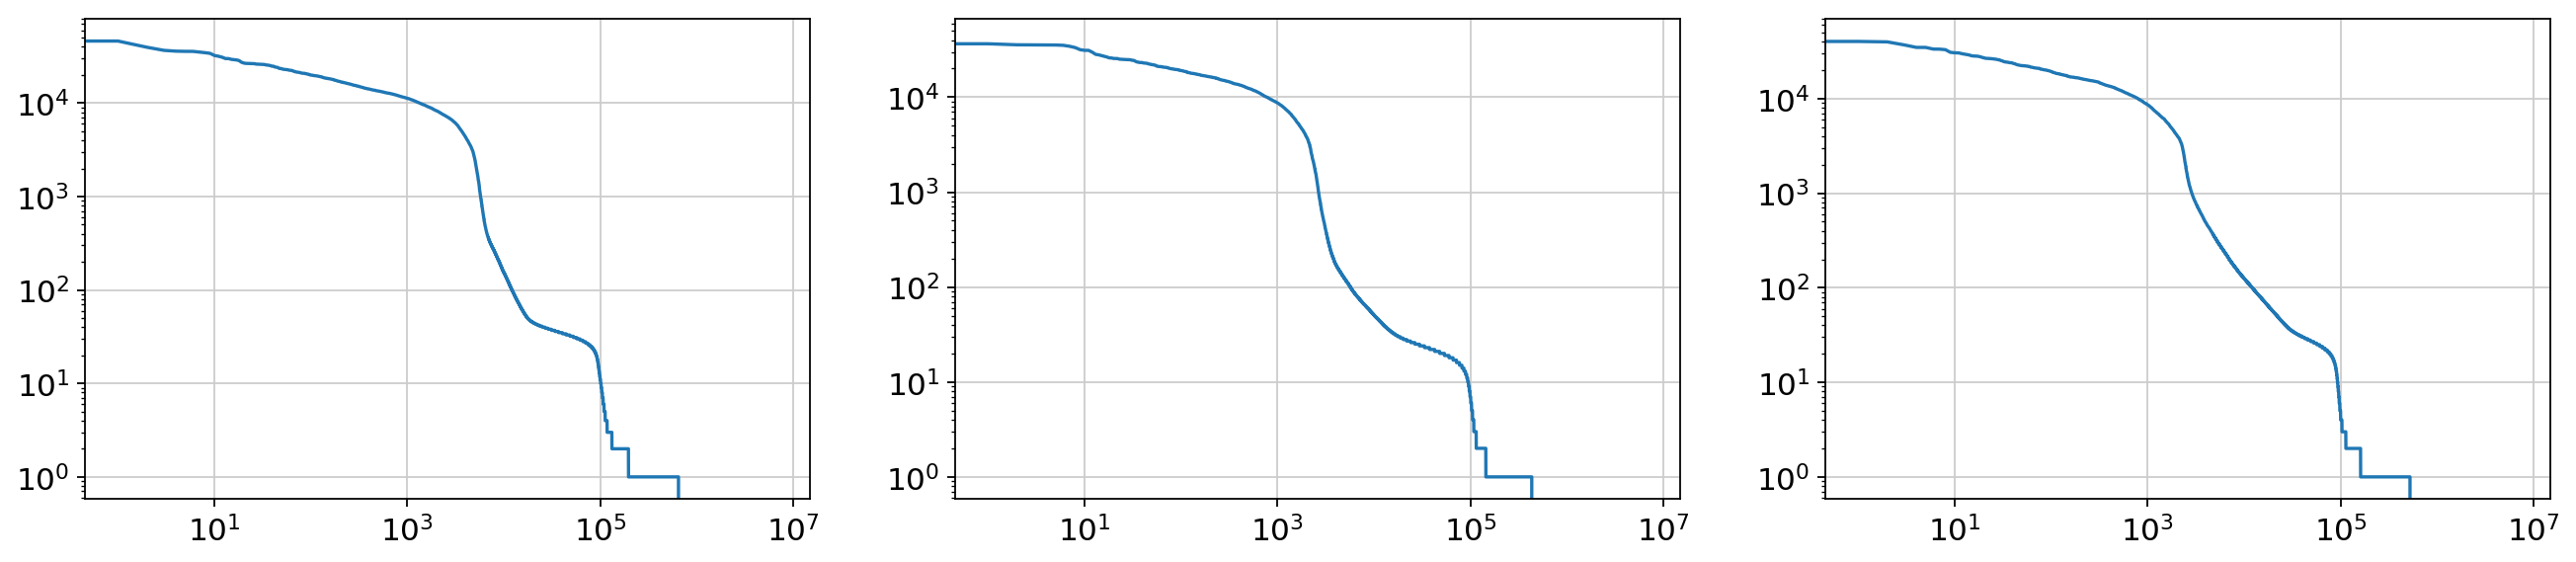

In [9]:
fig, axes = plt.subplots(1,3,figsize=(20,4))
for exp, ax in zip(exps, np.ravel(axes)):
    ax.plot(np.sort(np.ravel(exps[exp]['adata'].X.sum(1)))[::-1])
    ax.set_xscale('log')
    ax.set_yscale('log')

In [10]:
cells = [4500, 2500, 2500] # just 2.1 2.2 2.4

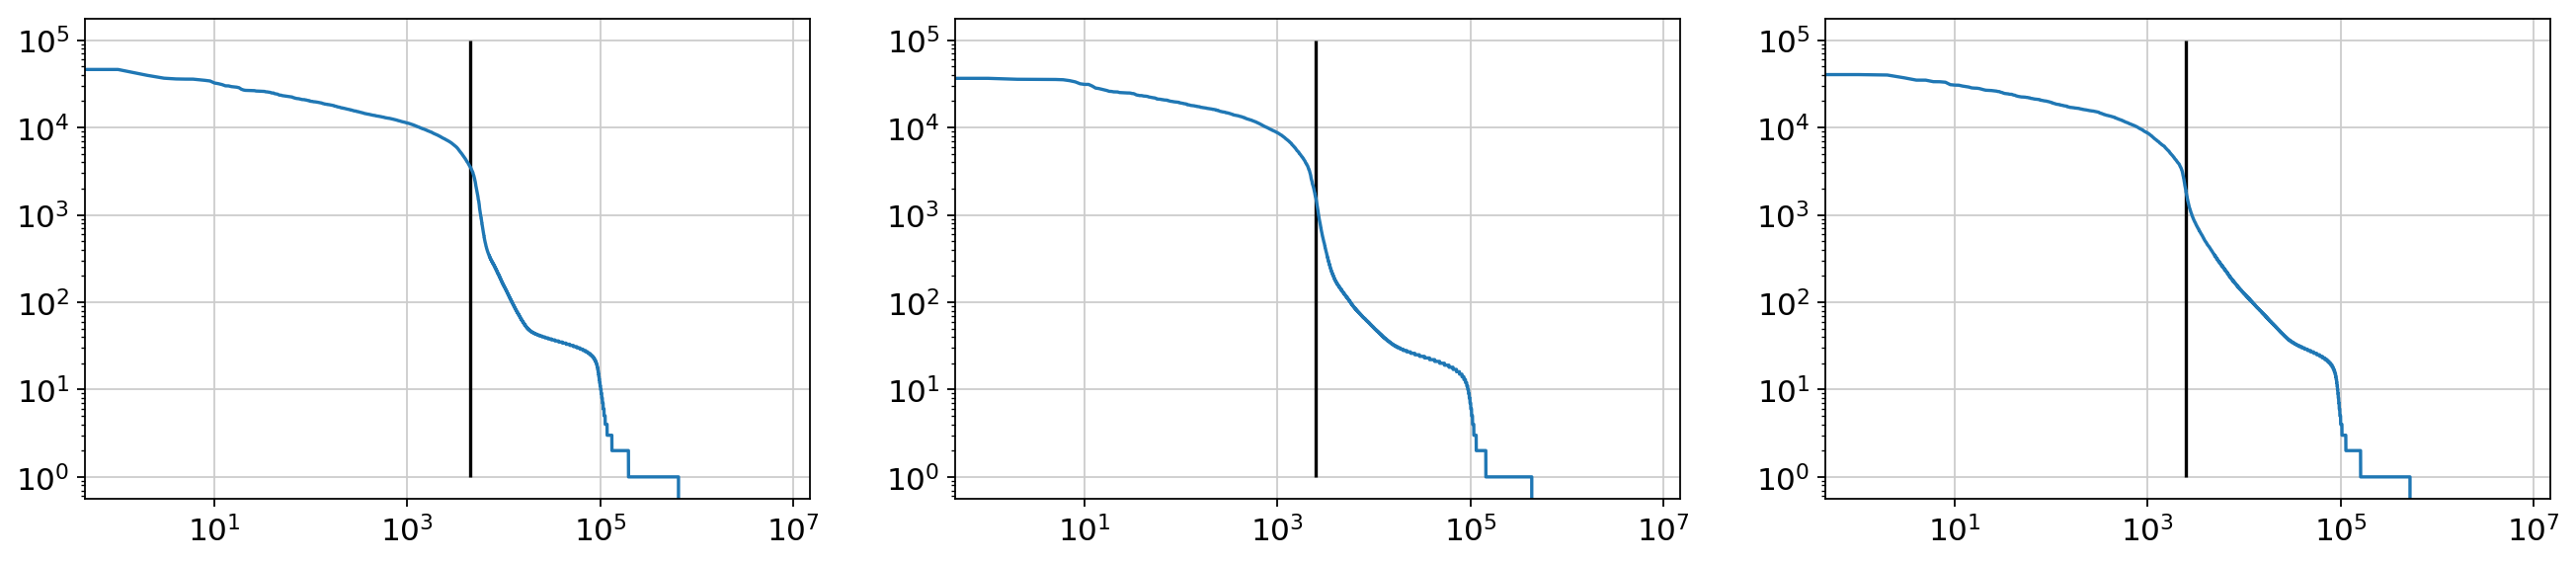

In [11]:
fig, axes = plt.subplots(1,3,figsize=(20,4))
for exp, ax, cell in zip(exps, np.ravel(axes), cells):
    ax.plot(np.sort(np.ravel(exps[exp]['adata'].X.sum(1)))[::-1])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.vlines(cell,1,1e5);

In [12]:
for exp in exps:
    obs = exps[exp]['adata'].obs.copy()
    obs['n_counts'] = np.ravel(exps[exp]['adata'].X.sum(1))
    exps[exp]['obs_n_counts'] = obs

In [13]:
for exp, cell in zip(exps, cells):
    exps[exp]['cell_number'] = cell

In [14]:
for exp in exps:
    exps[exp]['adata'] = exps[exp]['adata'][exps[exp]['obs_n_counts'].sort_values('n_counts', ascending=False)[:exps[exp]['cell_number']].index.values,:].copy()

In [15]:
for exp in exps:
    genelist_human = exps[exp]['adata'].var_names.tolist()
    genelist_mouse = exps[exp]['adata'].var_names.tolist()

    mito_genes_names_mouse = [gn for gn in genelist_mouse if gn.startswith('mt-')]

    exps[exp]['mito_genes_mouse'] = [genelist_mouse.index(gn) for gn in mito_genes_names_mouse]

Store percent mito in each sample:

In [16]:
for exp in exps:
    exps[exp]['adata'].obs['percent_mito'] = np.ravel(np.sum(exps[exp]['adata'][:, exps[exp]['mito_genes_mouse']].X, axis=1)) / np.ravel(np.sum(exps[exp]['adata'].X, axis=1))

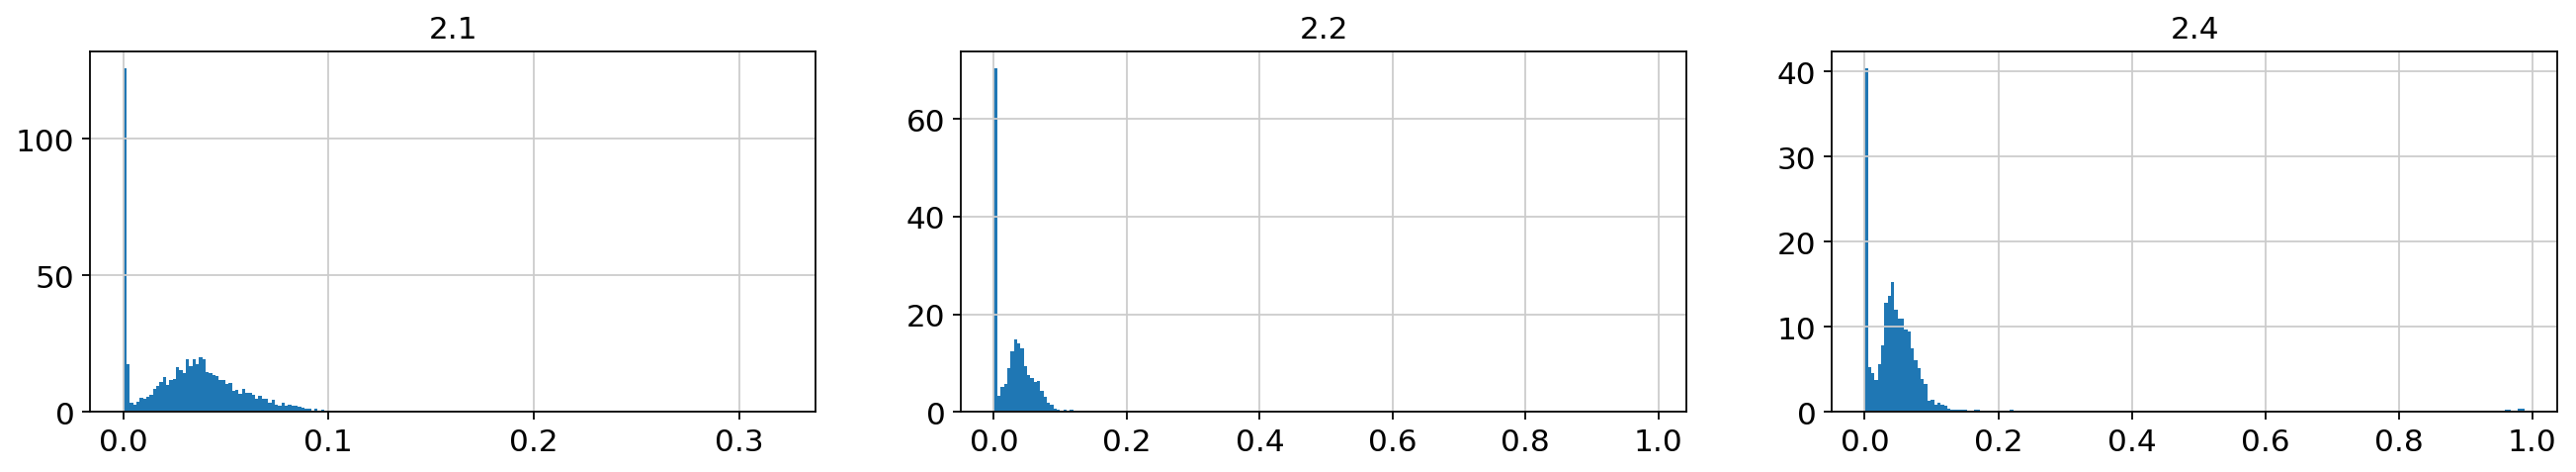

In [17]:
fig, axes = plt.subplots(1,3,figsize=(20,3))
for exp, ax in zip(exps,np.ravel(axes)):
    ax.hist(exps[exp]['adata'].obs['percent_mito'].values,bins=200,density=True)
    ax.set_title(exp)

In [18]:
for exp in exps:
    exps[exp]['adata'] = exps[exp]['adata'][exps[exp]['adata'].obs['percent_mito'] < 0.1].copy()

In [19]:
with open('/myvol/data2/exp.pkl','wb') as file:
    pkl.dump(exps, file)

In [21]:
# with open('/myvol/data2/exp.pkl','rb') as file:
#     exps = pkl.load(file)

In [20]:
def my_plot(ax, vals, tupe=None, thresh=None, max_y=None, low=1e-1, hi=2e5):
    ax.hist(vals,bins=np.logspace(np.log10(low),np.log10(hi), 500),color='gray') # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

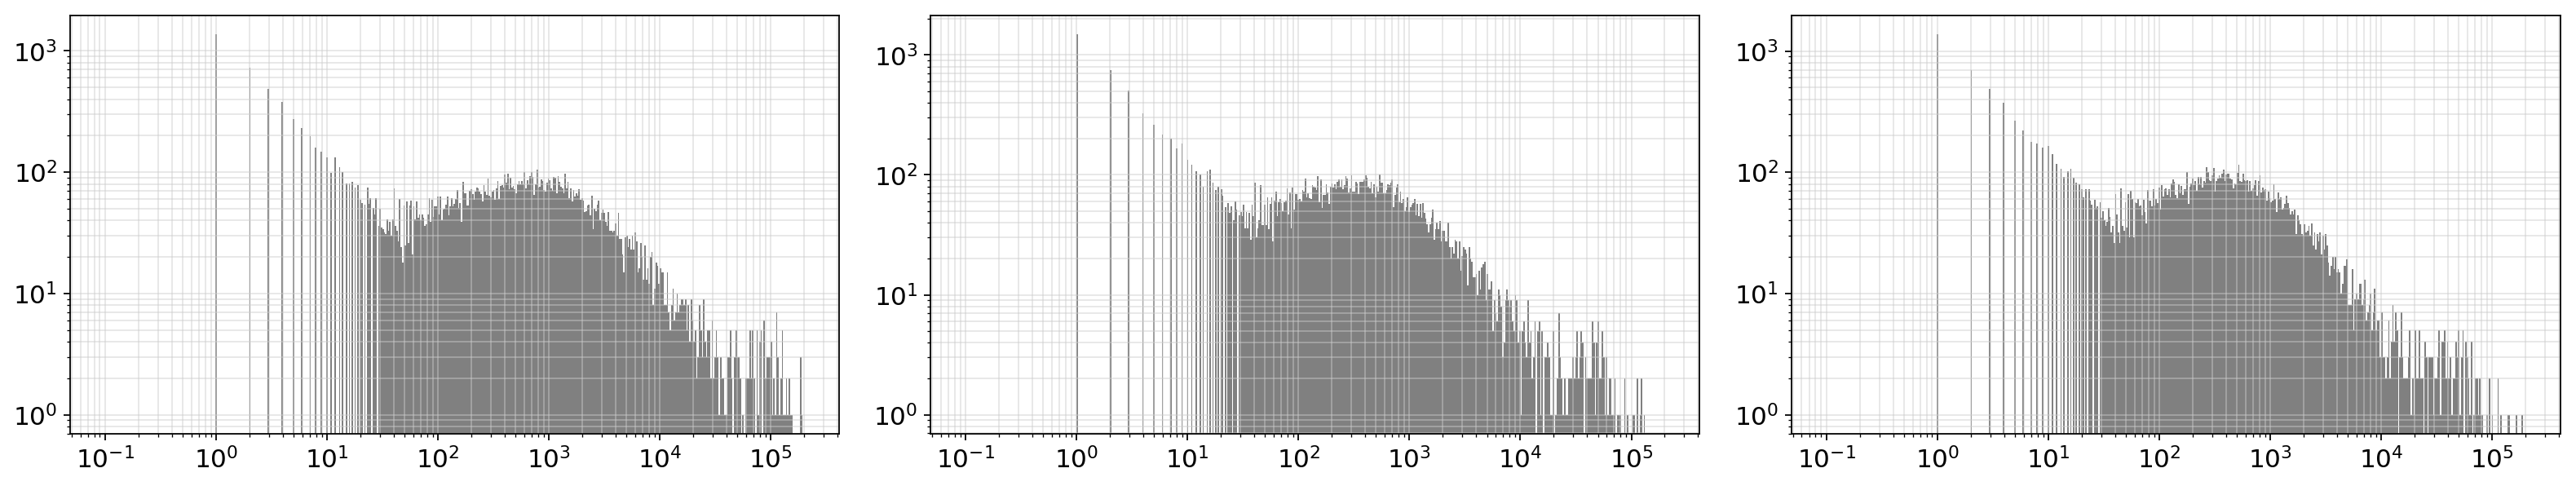

In [21]:
fig, axes = plt.subplots(1,3,figsize=(20,4))
for exp, ax in zip(exps,axes):
    vals = sc.pp.filter_genes(exps[exp]['adata'], min_counts=0, inplace=False)[1] # total number of UMIs observed
    my_plot(ax, vals)
plt.tight_layout()

In [22]:
min_counts = [50, 50, 50]

In [23]:
for exp, min_count in zip(exps,min_counts):
    sc.pp.filter_genes(exps[exp]['adata'], min_counts=min_count, inplace=True)
#     sc.pp.filter_genes(exps[exp]['adata'], max_counts=4e4, inplace=True)

filtered out 17294 genes that are detectedin less than 50 counts
filtered out 18384 genes that are detectedin less than 50 counts
filtered out 17889 genes that are detectedin less than 50 counts


In [24]:
for exp in exps:
    sc.pp.log1p(exps[exp]['adata'])
    sc.pp.normalize_per_cell(exps[exp]['adata'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [25]:
for exp in exps:    
#     warnings.filterwarnings('ignore')
    sc.pp.highly_variable_genes(exps[exp]['adata'], flavor='cell_ranger',inplace=True) # use default setting first to visualize
#     warnings.filterwarnings('default')

    a = sum(exps[exp]['adata'].var['highly_variable'].values)
    print(a, a/len(exps[exp]['adata'].var_names))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
6200 0.5792227204783259
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
5716 0.5945496151445808
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
6103 0.6037194579087941


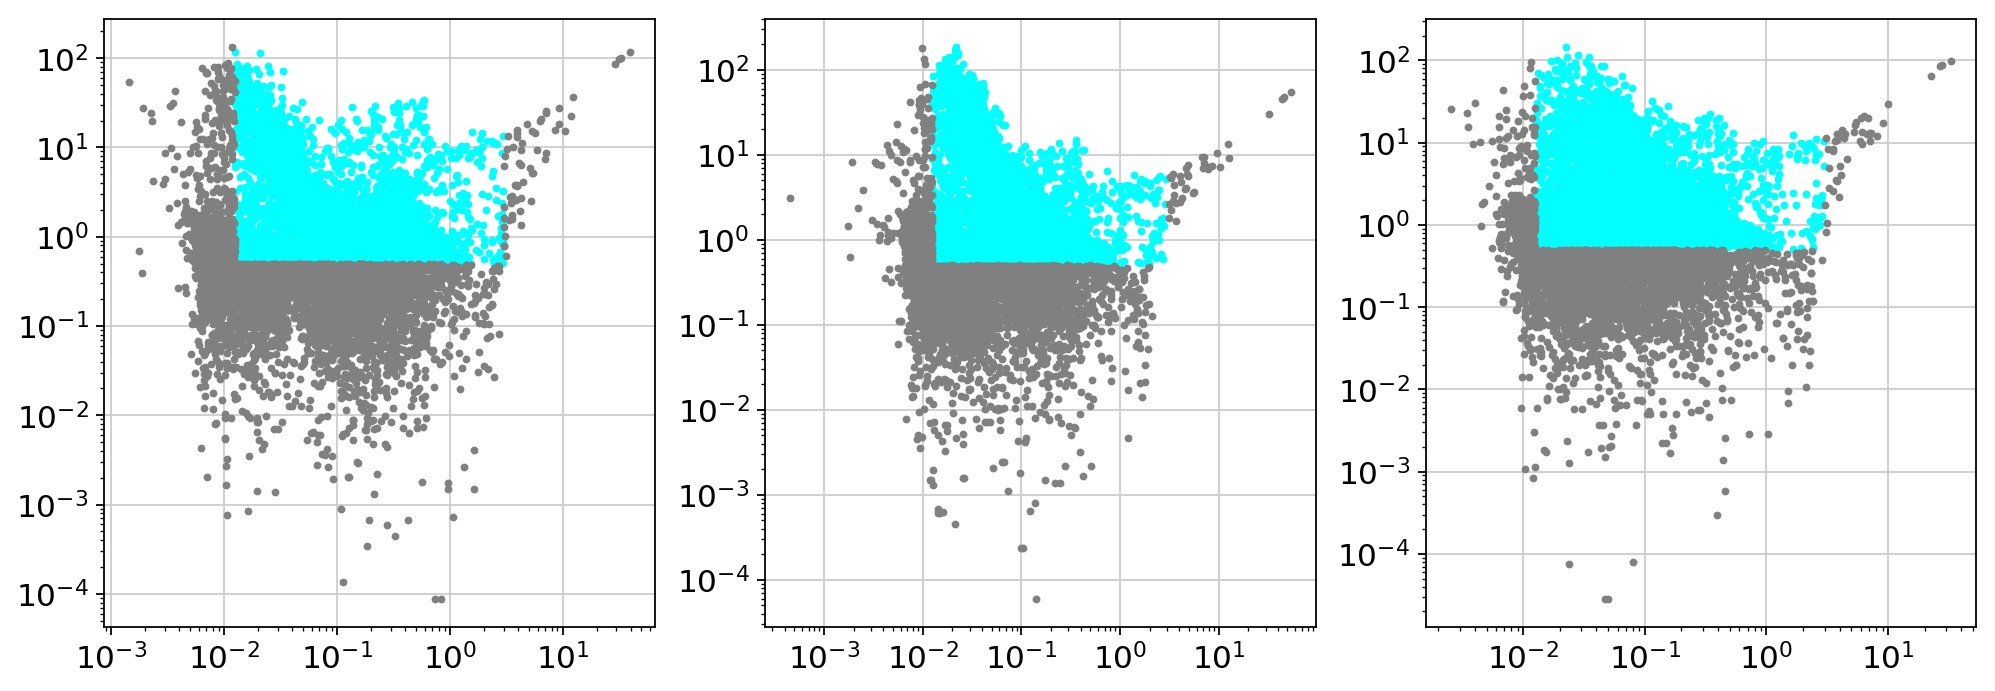

In [26]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for exp, ax in zip(exps, axes):
    hv = exps[exp]['adata'][:,exps[exp]['adata'].var['highly_variable'] == True].copy()
    nhv = exps[exp]['adata'][:,exps[exp]['adata'].var['highly_variable'] == False].copy()
    ax.plot(hv.var['means'].values,hv.var['dispersions_norm'].values,marker='.', markersize=5, linewidth=0, color='cyan');
    ax.plot(nhv.var['means'].values,nhv.var['dispersions_norm'].values,marker='.', markersize=5, linewidth=0, color='grey');
    ax.set_yscale('log')
    ax.set_xscale('log')

In [35]:
min_means = [8e-2, 8e-2, 1e-1]
min_disps = [7e-1, 5e-1, 6e-1]

In [36]:
for exp, min_mean, min_disp in zip(exps, min_means, min_disps):
    warnings.filterwarnings('ignore')
    sc.pp.highly_variable_genes(exps[exp]['adata'], flavor='cell_ranger',inplace=True, min_mean=min_mean, min_disp=min_disp, max_mean=np.inf) # use default setting first to visualize
    warnings.filterwarnings('default')
    a = sum(exps[exp]['adata'].var['highly_variable'].values)
    print(a, a/len(exps[exp]['adata'].var_names))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2421 0.22617713004484305
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2314 0.24069065945496151
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2242 0.22178256998714016


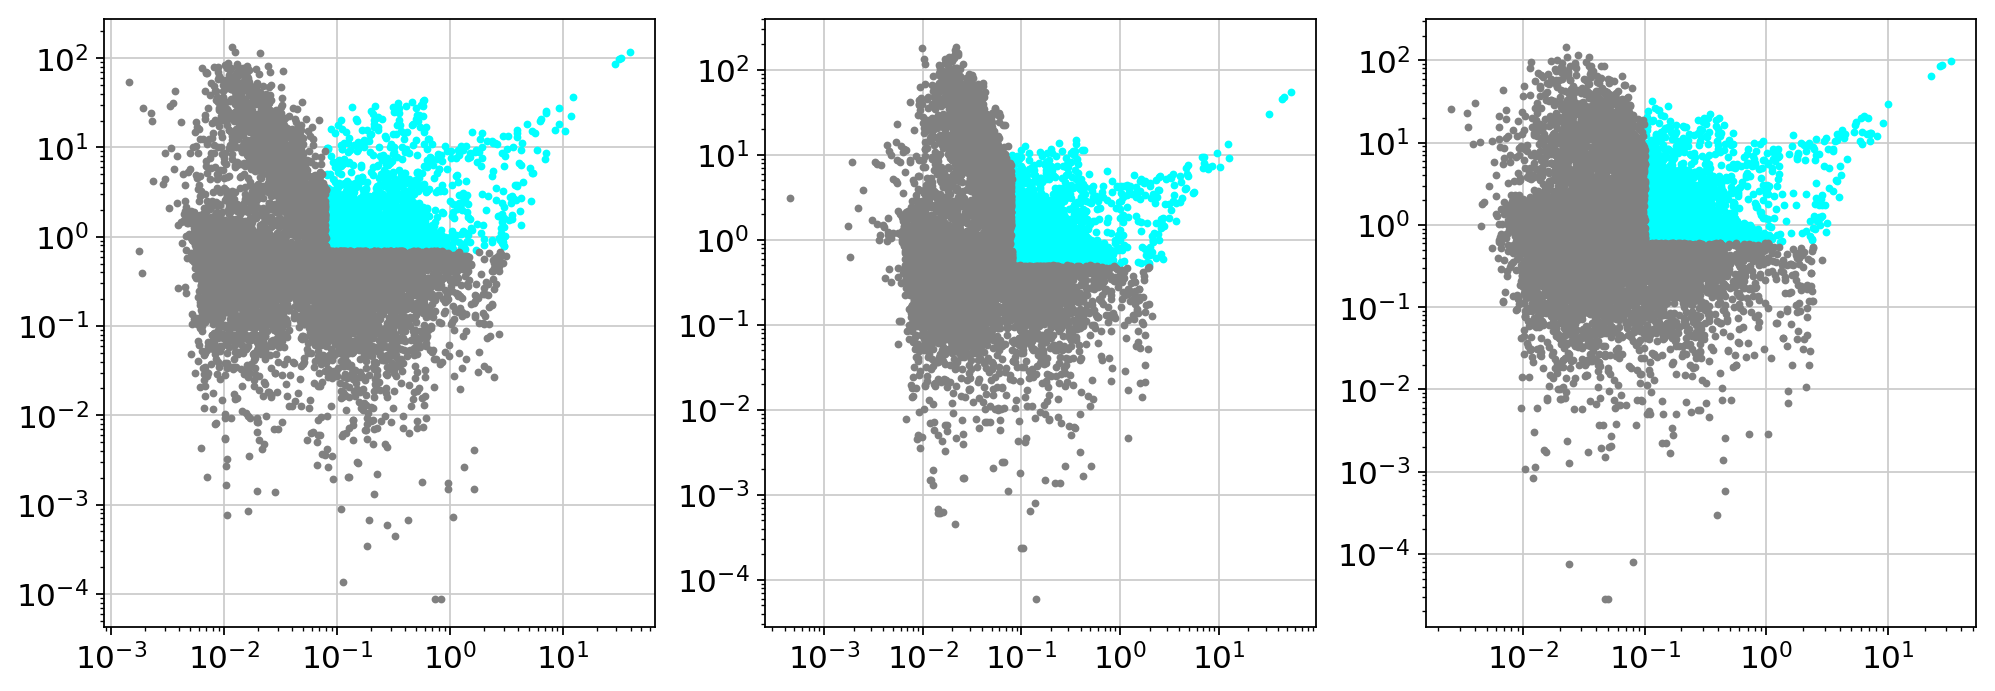

In [37]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for exp, ax in zip(exps, axes):
    hv = exps[exp]['adata'][:,exps[exp]['adata'].var['highly_variable'] == True].copy()
    nhv = exps[exp]['adata'][:,exps[exp]['adata'].var['highly_variable'] == False].copy()
    ax.plot(hv.var['means'].values,hv.var['dispersions_norm'].values,marker='.', markersize=5, linewidth=0, color='cyan');
    ax.plot(nhv.var['means'].values,nhv.var['dispersions_norm'].values,marker='.', markersize=5, linewidth=0, color='grey');
    ax.set_yscale('log')
    ax.set_xscale('log')

Cool, seems reasonable.

In [39]:
for exp, min_mean, min_disp in zip(exps, min_means, min_disps):
    warnings.filterwarnings('ignore')
    sc.pp.highly_variable_genes(exps[exp]['adata'], flavor='cell_ranger',inplace=True, subset=True, min_mean=min_mean, min_disp=min_disp, max_mean=np.inf) # use default setting first to visualize
    warnings.filterwarnings('default')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [40]:
for exp in exps:
    warnings.filterwarnings('ignore')
    sc.pp.regress_out(exps[exp]['adata'],['percent_mito','n_counts'],n_jobs=8)
    warnings.filterwarnings('default')
    sc.pp.scale(exps[exp]['adata'], max_value=10)

regressing out ['percent_mito', 'n_counts']
    sparse input is densified and may lead to high memory use


... storing 'feature_types' as categorical
... storing 'genome' as categorical


    finished (0:00:13)
regressing out ['percent_mito', 'n_counts']
    sparse input is densified and may lead to high memory use


... storing 'feature_types' as categorical
... storing 'genome' as categorical


    finished (0:00:01)
regressing out ['percent_mito', 'n_counts']
    sparse input is densified and may lead to high memory use


... storing 'feature_types' as categorical
... storing 'genome' as categorical


    finished (0:00:01)


In [123]:
# with open('/myvol/data2/data/pkls/exps.2.pkl','rb') as file:
#     exps = pkl.load(file)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
computing PCA on highly variable genes
    finished (0:00:00)


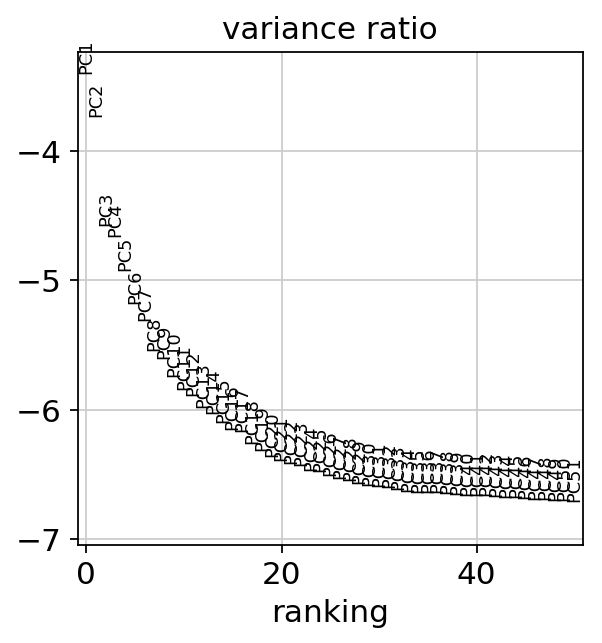

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
computing PCA on highly variable genes
    finished (0:00:00)


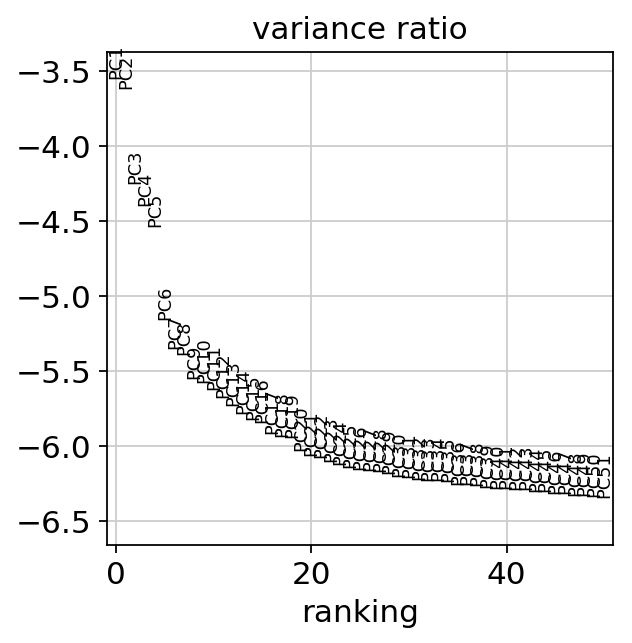

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
computing PCA on highly variable genes
    finished (0:00:00)


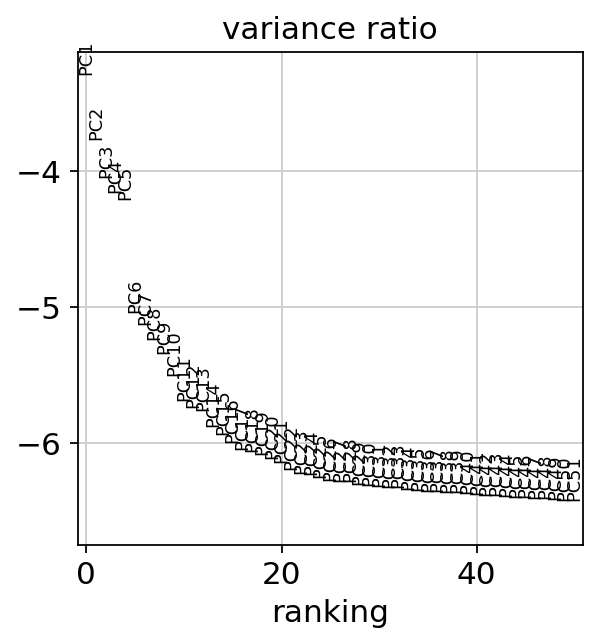

In [43]:
for exp in exps:
    sc.pp.pca(exps[exp]['adata'],n_comps=100)
    sc.pl.pca_variance_ratio(exps[exp]['adata'],log=True, n_pcs=50)

In [45]:
n_pcs = [40, 30, 30]

In [46]:
for exp, n_pc in zip(exps, n_pcs):
    warnings.filterwarnings('ignore')
    sc.pp.neighbors(exps[exp]['adata'],n_neighbors=15,n_pcs=n_pc) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
    warnings.filterwarnings('default')
    sc.tl.leiden(exps[exp]['adata'],resolution=0.3)
    sc.tl.umap(exps[exp]['adata'])#, min_dist=.05, spread=5, alpha=2)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each p

In [90]:
resolutions = [0.1, 0.1, 0.05]

In [91]:
for exp, res in zip(exps, resolutions):
    sc.tl.leiden(exps[exp]['adata'],resolution=res)

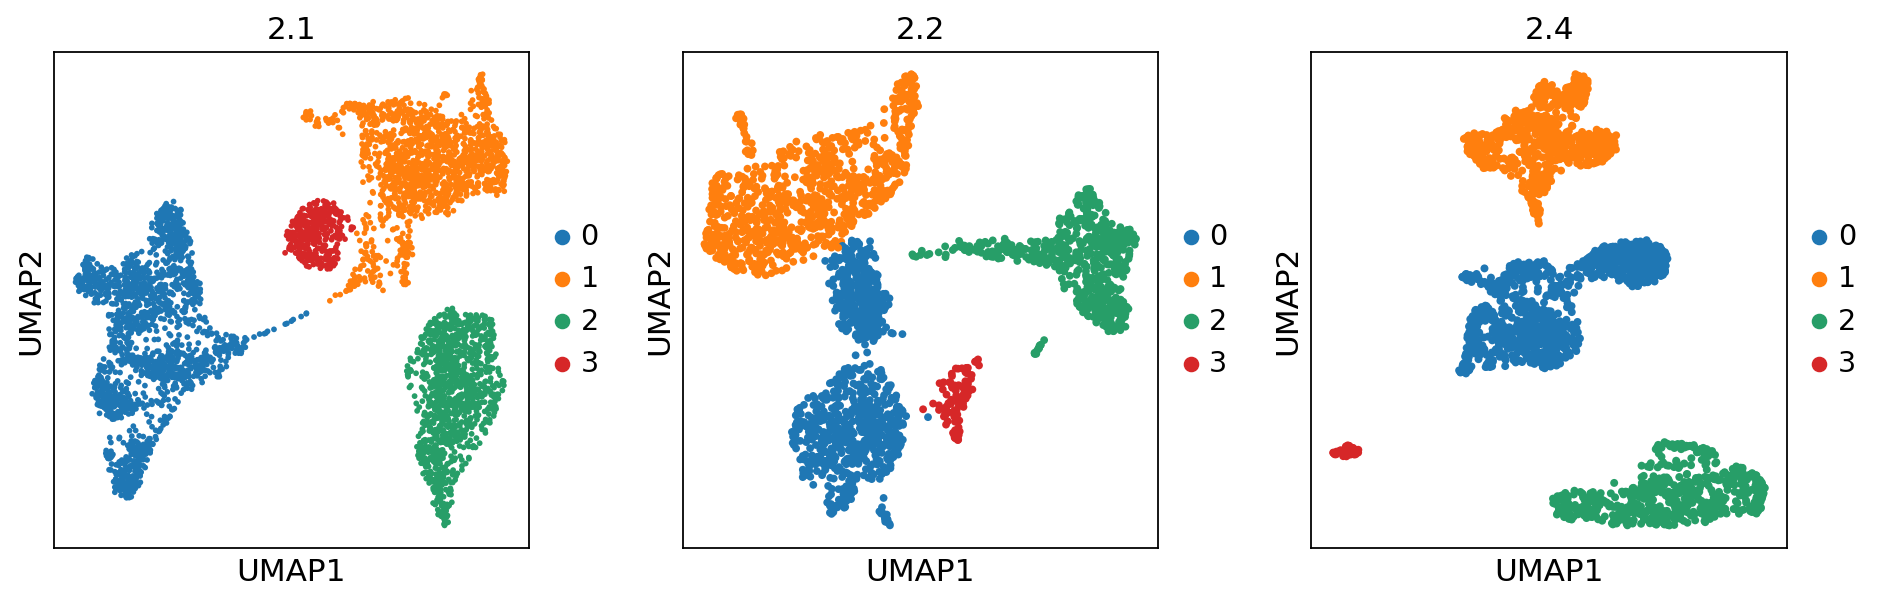

In [92]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
for exp, ax in zip(exps, np.ravel(axes)):
    sc.pl.umap(exps[exp]['adata'],color='leiden',ax=ax, return_fig=False, show=False, title=exp)
plt.tight_layout()

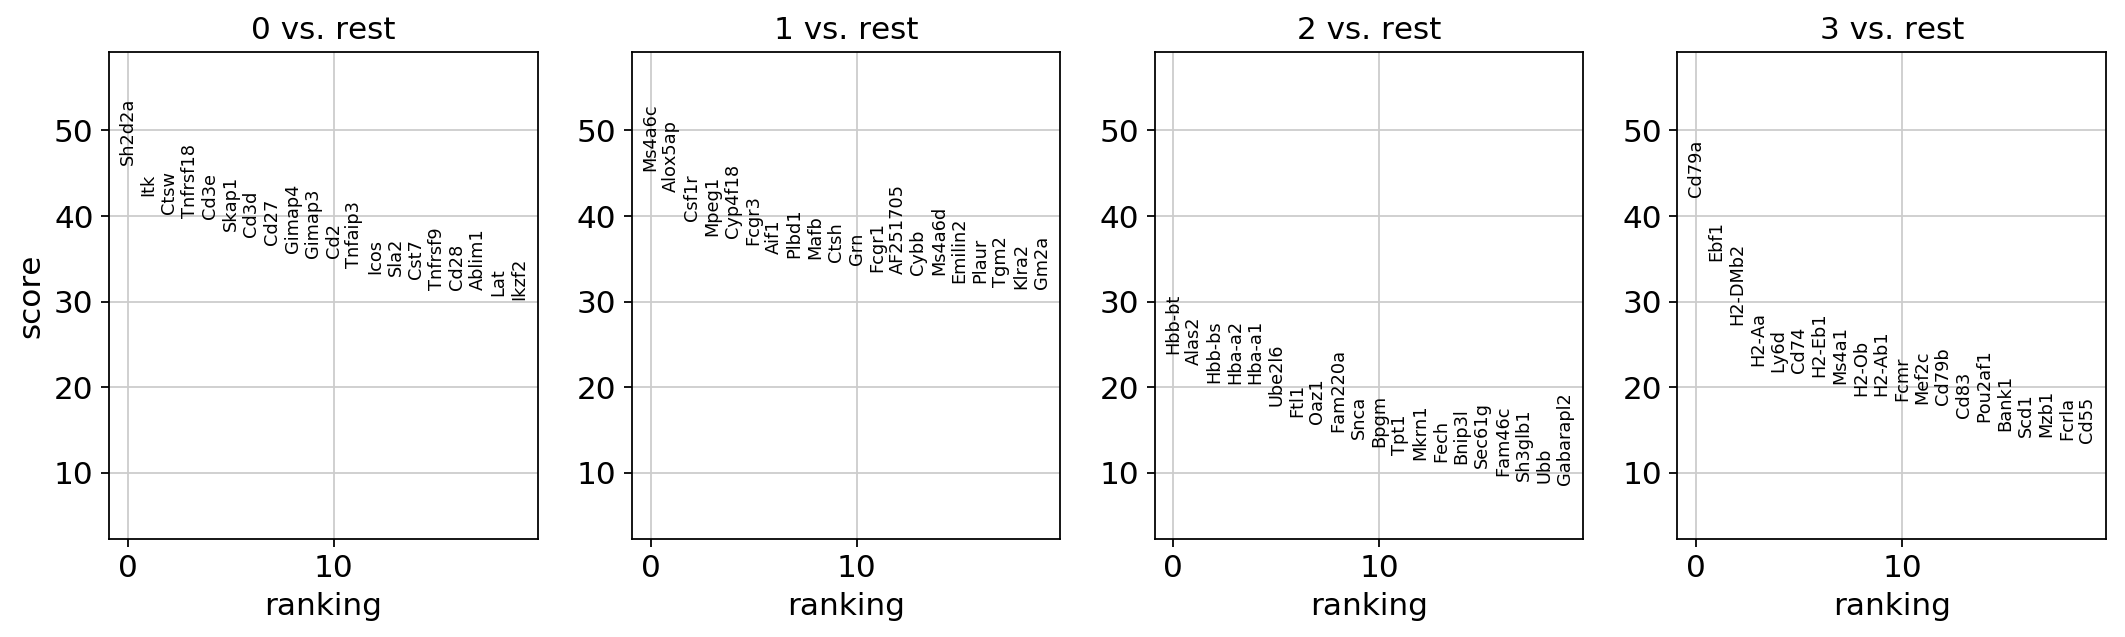

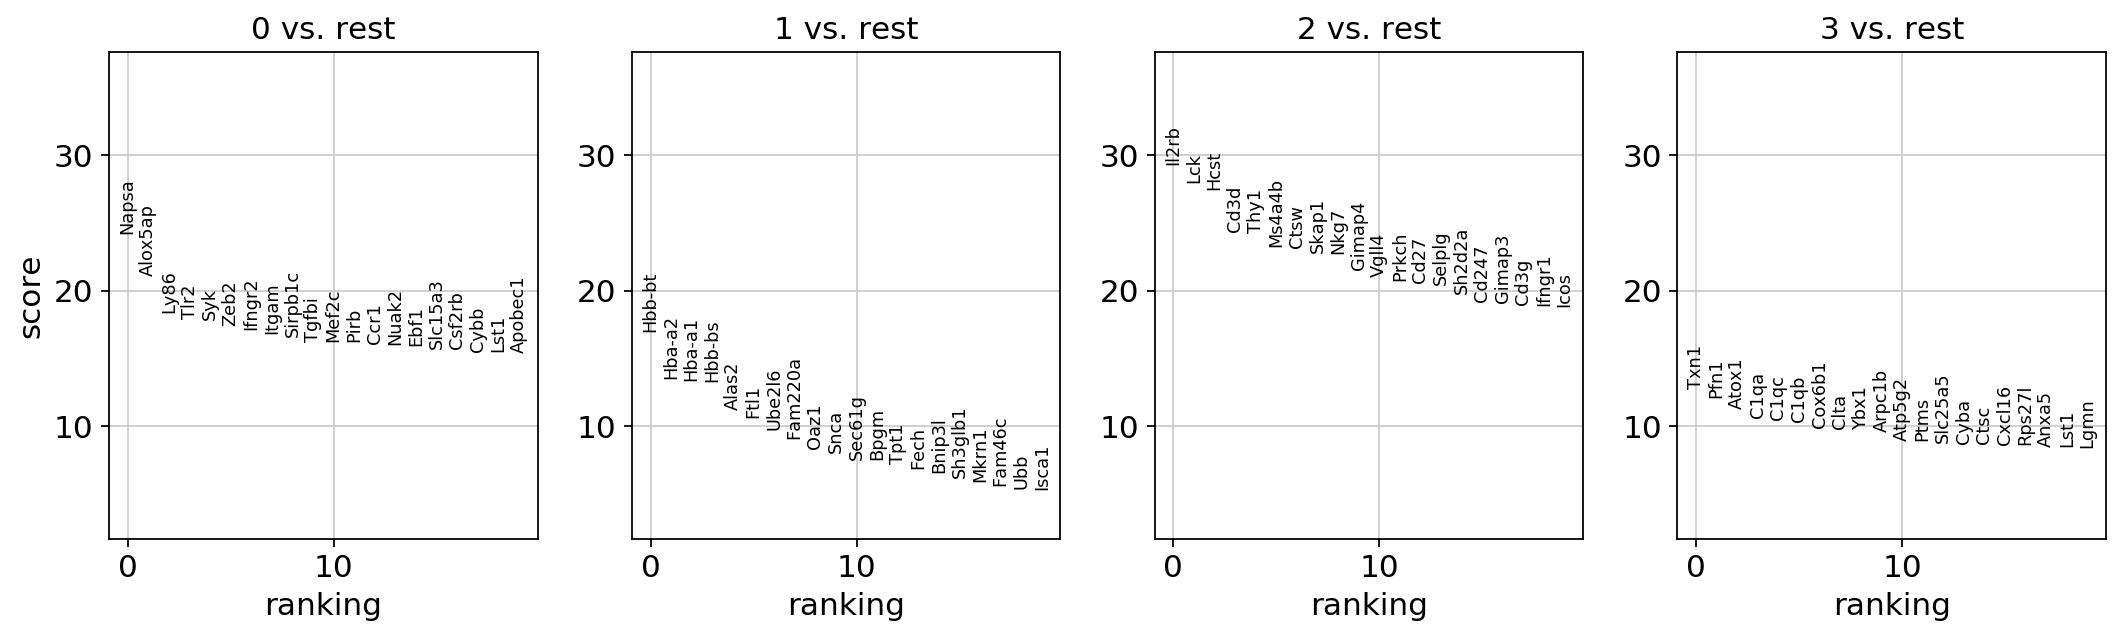

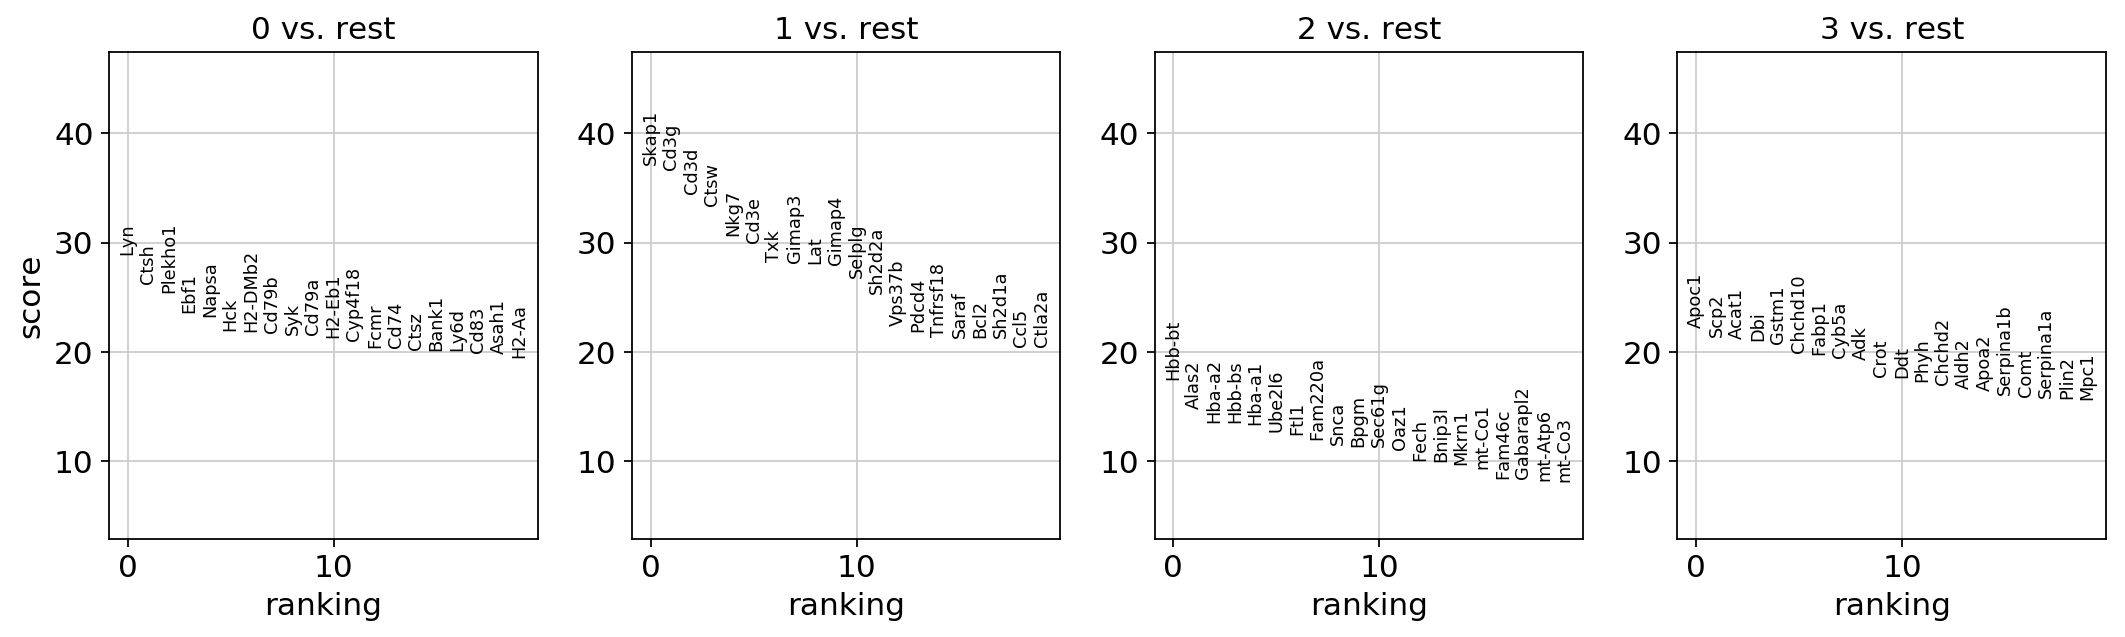

In [54]:
sc.settings.verbosity = 0
for exp in exps:
    warnings.filterwarnings('ignore')
    sc.tl.rank_genes_groups(exps[exp]['adata'],groupby='leiden')
    warnings.filterwarnings('default')
    sc.pl.rank_genes_groups(exps[exp]['adata'])

In [79]:
for exp in exps:
    exps[exp]['top10_genes'] = np.ravel(np.array([list(i) for i in exps[exp]['adata'].uns['rank_genes_groups']['names']])[:10,:])

In [81]:
np.intersect1d(np.intersect1d(exps['2.1']['top10_genes'],exps['2.2']['top10_genes']),exps['2.4']['top10_genes'])

array(['Alas2', 'Cd3d', 'Ctsw', 'Fam220a', 'Ftl1', 'Gimap4', 'Hba-a1',
       'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Skap1', 'Snca', 'Ube2l6'],
      dtype='<U13')

I think these datasets will be acceptable to concatenate into a single AnnData object. They definitely share 2 major populations (an immune population and the hepatocyte population). The third larger cluster in each dataset also has consistent subpopulations surrounding it, so although there was no common genes in the top 10, those are likely the cancer cells. I will reload in a separate notebook and run a concatenated version.